In [20]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
import os

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import xarray as xr
import dask as da
import geopandas as gpd
import cartopy as cart
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import emsarray as emr
from shapely.geometry import Point, Polygon, box, shape
from alphashape import alphashape
from tqdm.notebook import tqdm_notebook
import cmocean
import matplotlib.dates as mdates

from datetime import datetime, timedelta
import glob
import PyCO2SYS as pyco2
from IPython.display import display, HTML
import great_circle_calculator.great_circle_calculator as gcc
import gsw as sw

import math as math

%run /g/data/ih54/ha9300/oae/Notebooks/Model_Functions.ipynb

In [21]:
from scipy import interpolate

In [22]:
cluster = start_cluser(cores=24,hours=1,mins=00)
cluster.scale(jobs=1)
client = Client(cluster)
port = client.scheduler_info()['services']['dashboard']
client

/home/599/ha9300/miniconda3/envs/oet/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39897 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.4.64:39897/status,
Dashboard: http://10.6.4.64:39897/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.4.64:33589,Workers: 0
Dashboard: http://10.6.4.64:39897/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-34958' coro=<Client._gather.<locals>.wait() done, defined at /home/599/ha9300/miniconda3/envs/oet/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/home/599/ha9300/miniconda3/envs/oet/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-34953' coro=<Client._gather.<locals>.wait() done, defined at /home/599/ha9300/miniconda3/envs/oet/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/home/599/ha9300/miniconda3/envs/oet/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit


In [23]:
names = ['ebb','slack','flood','high_wind','low_wind','flood_wind']
cats = ['a','b','c']

In [24]:
def inputs_read(season='s'):

    inputs = {}
    
    names = ['ebb','slack','flood','high_wind','low_wind','flood_wind']
    cats = ['a','b','c']

    if season == 's':
    
        for i in range(3):
    
            inputs[cats[i]] = {}
    
            for name in names:
    
                inputs[cats[i]][name] = read_in_ts(f'/g/data/ih54/ha9300/oae/WB_Summer/Scenarios/{name}/{name}_pulse_{i}.ts')['alk']


    if season == 'w':
    
        for i in range(3):
    
            inputs[cats[i]] = {}
    
            for name in names:
    
                inputs[cats[i]][name] = read_in_ts(f'/g/data/ih54/ha9300/oae/WB_Winter/Scenarios/{name}/{name}_pulse_{i}.ts')['alk']
    
    return inputs

def r2(coeffs,x_data,y_data):

    y_pred = np.polyval(coeffs,x_data)

    tss = np.sum((y_data - np.mean(y_data))**2)
    rss = np.sum((y_data-y_pred)**2)

    r2 = 1 - (rss/tss)

    return r2

def fit_return(x,y,type='linear'):

    if type == 'linear':
        z = 1

    if type == 'quadratic':
        z=2

    coeffs = np.polyfit(x,y,z)
    fit_xy = np.poly1d(coeffs)
    x2 = np.linspace(np.min(x),np.max(x),1000)
    y2 = fit_xy(x2)

    r_sq = r2(coeffs,x,y)

    return x2,y2,r_sq


In [28]:
input = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Summer/inputs/in_depth_t.nc')
ctrl = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Summer/Control/control_20*.nc')

In [ ]:
w_ctrl = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Winter/Control/control_20*.nc')
w_input = read_shoc_nc('/g/data/ih54/ha9300/oae/WB_Winter/inputs/in_depth_t.nc')

In [29]:
strat = (ctrl.dens_0.isel(k=5).mean(dim=['i','j']) - ctrl.dens_0.isel(k=slice(16,19)).mean(dim=['i','j','k'])).values
w_strat = (w_ctrl.dens_0.isel(k=5).mean(dim=['i','j']) - w_ctrl.dens_0.isel(k=slice(16,19)).mean(dim=['i','j','k'])).values

In [30]:
summer = {'mass_alk':{'a':pd.read_csv('mass_alkalinity_condition_experiments_summer_0.csv'),
                      'b':pd.read_csv('mass_alkalinity_condition_experiments_summer_1.csv'),
                      'c':pd.read_csv('mass_alkalinity_condition_experiments_summer_2.csv'),},
          
          'mass_dic':{'a':pd.read_csv('mass_DIC_condition_experiments_summer_0.csv'),
                      'b':pd.read_csv('mass_DIC_condition_experiments_summer_1.csv'),
                      'c':pd.read_csv('mass_DIC_condition_experiments_summer_2.csv'),},
          
          'alk_1m':  {'a':pd.read_csv('surface_1m_alk_mass_summer_0.csv'),
                      'b':pd.read_csv('surface_1m_alk_mass_summer_1.csv'),
                      'c':pd.read_csv('surface_1m_alk_mass_summer_2.csv'),},
                      }

winter = {'mass_alk':{'a':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/mass_alkalinity_condition_experiments_Winter_0.csv'),
                      'b':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/mass_alkalinity_condition_experiments_Winter_1.csv'),
                      'c':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/mass_alkalinity_condition_experiments_Winter_2.csv'),},
          
          'mass_dic':{'a':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/mass_DIC_condition_experiments_Winter_0.csv'),
                      'b':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/mass_DIC_condition_experiments_Winter_1.csv'),
                      'c':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/mass_DIC_condition_experiments_Winter_2.csv'),},
          
          'alk_1m':  {'a':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/surface_1m_alk_mass_Winter_0.csv'),
                      'b':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/surface_1m_alk_mass_Winter_1.csv'),
                      'c':pd.read_csv('/g/data/ih54/ha9300/oae/WB_Winter/Notebooks/surface_1m_alk_mass_Winter_2.csv'),},
                      }

In [31]:
w_input_ts = inputs_read(season='w')
s_input_ts = inputs_read(season='s')

plumes = pd.read_csv('summer_plume_size.csv')
w_plumes = pd.read_csv('winter_plume_size.csv')

In [32]:
def calculate_efficiency(mass_alk, mass_dic, input_ts, cats, names, season_label):
    """Calculate experiment efficiency and trim the results based on input timestamps."""
    experiment_efficiency = {}
    eff_trim = []
    idxs = []

    for i in cats:
        experiment_efficiency[i] = {}
        for name in names:
            alk_D = mass_alk[i][name] - mass_alk[i]['ctrl']
            dic_D = mass_dic[i][name] - mass_dic[i]['ctrl']
            
            # Calculate efficiency
            experiment_efficiency[i][name] = [safe_div(x, y) for x, y in zip((dic_D / 12.011), alk_D)]

            # Get trimming index
            idx = np.where(input_ts[i][name] > 0)[0][0] - 1
            idxs.append(idx)

            # Trim efficiency data
            eff_trim.append(experiment_efficiency[i][name][idx:])

    # Pad the trimmed efficiency lists and return as a DataFrame
    max_length = max(len(lst) for lst in eff_trim)
    padded_eff = [lst + [np.nan] * (max_length - len(lst)) for lst in eff_trim]
    
    return pd.DataFrame(padded_eff).transpose()


def calculate_surface_fraction(mass_alk, alk_1m, input_ts, cats, names, season_label):
    """Calculate alk surface fraction and trim the results based on input timestamps."""
    alk_surf_frac = {}
    surf_trim = []
    idxs = []

    for i in cats:
        alk_surf_frac[i] = {}
        for name in names:
            alk_D = mass_alk[i][name] - mass_alk[i]['ctrl']
            alk_surf_sum = alk_1m[i][name] - alk_1m[i]['ctrl']
            
            # Calculate surface fraction
            alk_surf_frac[i][name] = [safe_div(x, y) for x, y in zip(alk_surf_sum, alk_D)]

            # Get trimming index
            idx = np.where(input_ts[i][name] > 0)[0][0] - 1
            idxs.append(idx)

            # Trim surface fraction data
            surf_trim.append(alk_surf_frac[i][name][idx:])

    # Pad the trimmed surface fraction lists and return as a DataFrame
    max_length = max(len(lst) for lst in surf_trim)
    padded_surf = [lst + [np.nan] * (max_length - len(lst)) for lst in surf_trim]
    
    return pd.DataFrame(padded_surf).transpose()


# Calculate winter efficiency and surface fraction
padded_eff = calculate_efficiency(summer['mass_alk'], summer['mass_dic'], s_input_ts, cats, names, 'Summer')
padded_surf = calculate_surface_fraction(summer['mass_alk'], summer['alk_1m'], s_input_ts, cats, names, 'Summer')

# Calculate summer efficiency and surface fraction
padded_eff_winter = calculate_efficiency(winter['mass_alk'], winter['mass_dic'], w_input_ts, cats, names, 'Winter')
padded_surf_winter = calculate_surface_fraction(winter['mass_alk'], winter['alk_1m'], w_input_ts, cats, names, 'Winter')

In [33]:
summer_idx = []
winter_idx = []

for i in cats:
    for name in names:
        s_idx = np.where(s_input_ts[i][name] > 0)[0][0]
        summer_idx.append(np.sum(strat[s_idx:]))
        
        w_idx = (np.where(s_input_ts[i][name] > 0)[0][0])
        winter_idx.append(np.sum(w_strat[w_idx:]))

summer_strat_x,summer_alk_x,summer_r2 = fit_return(summer_idx,padded_surf.sum(axis=0))
winter_strat_x,winter_alk_x,winter_r2 = fit_return(winter_idx,padded_surf_winter.sum(axis=0))

In [35]:
strats,w_strats = [],[]
plume_len,w_plume_len = [],[]
size,w_size = [],[]

for i in cats:

    for name in names:
        strats.append(np.trapz(strat[np.where(plumes[f'{i}_{name}'] > 0)]))
        plume_len.append(len(np.where(plumes[f'{i}_{name}'] > 0)[0]))
        size.append(np.trapz(plumes[f'{i}_{name}']))
    
        w_strats.append(np.trapz(w_strat[np.where(w_plumes[f'{i}_{name}'] > 0)]))
        w_plume_len.append(len(np.where(w_plumes[f'{i}_{name}'] > 0)[0]))
        w_size.append(np.trapz(w_plumes[f'{i}_{name}']))


In [36]:
old_min = min(strats)
old_max = max(strats)

strats_normed = normalized_values = [
    10 + (value - old_min) * (50 - 5) / (old_max - old_min) 
    for value in strats
]

w_strats_normed = normalized_values = [
    10 + (value - old_min) * (50 - 5) / (old_max - old_min) 
    for value in w_strats
]

w_strats_normed

[14.935798940101051,
 14.53025650368366,
 10.166378518296227,
 12.16419000868838,
 11.294552215582762,
 9.889032436459008,
 11.153330229129974,
 12.738691120514144,
 9.588215247988703,
 9.917122856631583,
 17.61304486745252,
 9.76069042784831,
 11.569588640650236,
 10.885680544181954,
 9.315238787067218,
 12.436126083677546,
 10.62529275304151,
 11.102829895975278]

In [37]:
mean_surf_alk_summer = []
max_eff_summer = []
mean_surf_alk_winter = []
max_eff_winter = []

max_alk_surf = []
max_alk_surf_w = []

for i in cats:
    for name in names:
        mean_surf_alk_summer.append(np.mean(alk_surf_frac[i][name]))
        max_eff_summer.append(np.nanmax(experiment_efficiency_summer[i][name]))
        max_alk_surf.append(np.nanmax(alk_surf_frac[i][name]))
        
        mean_surf_alk_winter.append(np.mean(alk_surf_frac_w[i][name]))
        max_eff_winter.append(np.nanmax(experiment_efficiency_winter[i][name]))
        max_alk_surf_w.append(np.nanmax(alk_surf_frac_w[i][name]))

surf_summer_x,eff_summer_y,eff_surf_summer_r2 = fit_return(mean_surf_alk_summer,max_eff_summer,type='linear')
surf_winter_x,eff_winter_x,eff_surf_winter_r2 = fit_return(mean_surf_alk_winter,max_eff_winter,type='linear')

Text(0, 0.5, '$\\eta$CO$_2$ ($\\Delta$DIC/$\\Delta$TA)')

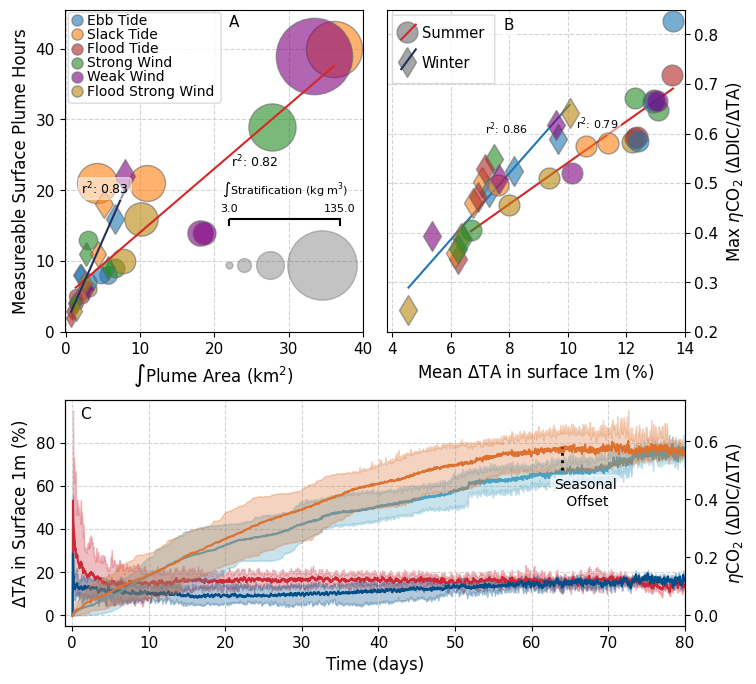

In [38]:
fig = plt.figure(figsize=(8,8),constrained_layout=False)

gs = fig.add_gridspec(2,2,wspace=0.08,hspace=0.25,height_ratios=[1,0.7],)#

axes = {'ax_0' : fig.add_subplot(gs[0,0]),
        'ax_1' : fig.add_subplot(gs[0,1]),
        'ax_2' : fig.add_subplot(gs[1,0:2]),
       }

plume_time_strat_x,plume_time_strat_y,plume_time_strat_r2 = fit_return(strats,plume_len,type='linear')
plume_time_area_x,plume_time_area_y,plume_time_area_r2 = fit_return(size,plume_len,type='linear')
area_strat_x,area_strat_y,area_strat_r2 = fit_return(size,strats,type='linear')
w_plume_time_area_x,w_plume_time_area_y,w_plume_time_area_r2 = fit_return(w_size,w_plume_len,type='linear')

colors = ['tab:blue','tab:orange','firebrick','forestgreen','purple','darkgoldenrod']
colors2 = colors*3


for i in range(3):
    axes[f'ax_{i}'].grid(linestyle='--',color='lightgrey')

for i,b in enumerate(size):
    axes['ax_0'].plot(size[i],plume_len[i],linestyle='',marker='o',alpha=0.6,markeredgecolor='dimgrey',markersize=strats_normed[i],color=colors2[i])
    
for i,b in enumerate(size):
    axes['ax_0'].plot(w_size[i],w_plume_len[i],linestyle='',marker='d',alpha=0.6,markeredgecolor='dimgrey',markersize=w_strats_normed[i],color=colors2[i])
    
axes['ax_0'].plot(plume_time_area_x,plume_time_area_y,color='tab:red')
axes['ax_0'].plot(w_plume_time_area_x,w_plume_time_area_y,color='#1F305E')
axes['ax_0'].set_xlabel('∫Plume Area (km$^2$)')
axes['ax_0'].set_ylabel('Measureable Surface Plume Hours')

axes['ax_0'].text(22.2,23.3,f'r$^2$: {np.round(plume_time_area_r2,2)}',fontsize = 9)
axes['ax_0'].text(2,19.5,f'r$^2$: {np.round(w_plume_time_area_r2,2)}',fontsize = 9,bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'})

axes['ax_0'].set_xlim(-0.2,40)
axes['ax_0'].set_ylim(0,45.5)

xs = [22,24,27.5,34.5]
ys = [9.5,9.5,9.5,9.5]
ss = [5,10,20,50]

for i,b in enumerate(xs):
    axes['ax_0'].plot(xs[i],ys[i],markersize=ss[i],marker='o',linestyle='',color='dimgrey',alpha=0.4)

axes['ax_0'].hlines(16,21.97,37.03,color='k')
axes['ax_0'].vlines(22,15,16,color='k')
axes['ax_0'].vlines(37,15,16,color='k')
axes['ax_0'].text(((37+22)/2),19.5,'∫Stratification (kg m$^3$)',ha='center',fontsize = 8, bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'})

axes['ax_0'].text(22,17,f'{np.round(min(strats),0)}',ha='center',fontsize = 8,bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'})
axes['ax_0'].text(36.9,17,f'{np.round(max(strats),0)}',ha='center',fontsize = 8,bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'})

ys2 = [44,42,40,38,36,34]

fancy_names = ['Ebb Tide',
               'Slack Tide',
               'Flood Tide',
               'Strong Wind',
               'Weak Wind',
               'Flood Strong Wind'
              ]

from matplotlib import patches

h,w = 32.5-45.5,0.2-21
rect = patches.FancyBboxPatch((21,45.2),w,h,edgecolor='lightgrey',facecolor='white',
                         boxstyle=f"round,pad=0.1,rounding_size=-0.4",
                         alpha=0.8,zorder=4,linewidth=1)

axes['ax_0'].add_patch(rect)

for i,b in enumerate(colors):
    axes['ax_0'].plot(1.5,ys2[i],marker='o',linestyle='',color=colors[i],alpha=0.6,markeredgecolor='dimgrey',zorder=5)
    axes['ax_0'].text(2.8,ys2[i]-0.6,fancy_names[i],fontsize=10,zorder=5)

axes['ax_0'].text(22,43.5-0.47,'A',fontsize=11,
                            bbox={'facecolor': 'white', 'edgecolor':'white',
                            'alpha':0.7, 'boxstyle': 'round, pad=0.2'},zorder=7)

##################################################################


h,w = 0.7-0.84,4-7.5
rect = patches.FancyBboxPatch((7.5,0.84),w,h,edgecolor='lightgrey',facecolor='white',
                         boxstyle=f"round,pad=0.001,rounding_size=-0.001",
                         alpha=0.8,zorder=4,linewidth=1)
axes['ax_1'].add_patch(rect)

axes['ax_1'].plot(4.5,0.805,marker='o',linestyle='',color='dimgrey',alpha=0.6,markeredgecolor='dimgrey',markersize=15,zorder=5)
axes['ax_1'].plot([4.3,4.8],[0.79,0.82],color='tab:red',alpha=1,zorder=5,linewidth=1.5)

axes['ax_1'].plot(4.5,0.745,marker='d',linestyle='',color='dimgrey',alpha=0.6,markeredgecolor='dimgrey',markersize=15,zorder=5)
axes['ax_1'].plot([4.3,4.8],[0.73,0.77],color='#1F305E',alpha=1,zorder=5,linewidth=1.5)

axes['ax_1'].text(5,0.805-0.012,'Summer',fontsize=10.5,zorder=5)
axes['ax_1'].text(5,0.745-0.012,'Winter',fontsize=10.5,zorder=5)

axes['ax_1'].text(11,0.61,f'r$^2$: {np.round(eff_surf_summer_r2,2)}',ha='center',fontsize = 8,bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'})
axes['ax_1'].text(7.9,0.6,f'r$^2$: {np.round(eff_surf_winter_r2,2)}',ha='center',fontsize = 8,bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'})

for i,x in enumerate(mean_surf_alk_summer):
    
    axes['ax_1'].plot(mean_surf_alk_summer[i]*100,max_eff_summer[i],marker='o',color=colors2[i],markersize=15,alpha=0.6,markeredgecolor='dimgrey',zorder=5)
    axes['ax_1'].plot(mean_surf_alk_winter[i]*100,max_eff_winter[i],marker='d',color=colors2[i],markersize=15,alpha=0.6,markeredgecolor='dimgrey',zorder=5)

axes['ax_1'].plot(surf_summer_x*100,eff_summer_y,color='tab:red')
axes['ax_1'].plot(surf_winter_x*100,eff_winter_x,color='tab:blue')

axes['ax_1'].yaxis.tick_right()           # Move the ticks to the right
axes['ax_1'].yaxis.set_label_position("right")  # Move the label to the right
axes['ax_1'].spines['right'].set_position(('outward', 0))  # Make the right spine visible

axes['ax_1'].set_xlabel(r'Mean $\Delta$TA in surface 1m (%)')
axes['ax_1'].set_ylabel(r'Max $\eta$CO$_2$ ($\Delta$DIC/$\Delta$TA)')
axes['ax_1'].set_xlim(3.8,14)
axes['ax_1'].set_ylim(0.2,0.85)

axes['ax_1'].text(7.8,0.81,'B',fontsize=11,
                            bbox={'facecolor': 'white', 'edgecolor':'white',
                            'alpha':0.7, 'boxstyle': 'round, pad=0.2'},zorder=7)


##################################################################

axes['ax_2'].fill_between([x/24 for x in range(len(padded_surf.mean(axis=1)))],
                 padded_surf.quantile(q=0.1,axis=1)*100,
                 padded_surf.quantile(q=0.90,axis=1)*100,
                 alpha=0.3,zorder=0,color='#CC2936')

axes['ax_2'].plot([x/24 for x in range(len(padded_surf.mean(axis=1)))],
         padded_surf.mean(axis=1)*100,linewidth=1.5,zorder=2,color='#CC2936')

axes['ax_2'].fill_between([x/24 for x in range(len(padded_surf_winter.mean(axis=1)))],
                 padded_surf_winter.quantile(q=0.1,axis=1)*100,
                 padded_surf_winter.quantile(q=0.90,axis=1)*100,
                 alpha=0.3,zorder=0,color='#004E89')

axes['ax_2'].plot([x/24 for x in range(len(padded_surf_winter.mean(axis=1)))],
         padded_surf_winter.mean(axis=1)*100,linewidth=1.5,zorder=2,color='#004E89')

axes['ax_2'].set_xlim(-1,80)
axes['ax_2'].set_ylabel(r'$\Delta$TA in Surface 1m (%)')
axes['ax_2'].set_xlabel('Time (days)')
        
ax2 = axes['ax_2'].twinx()

ax2.fill_between([x/24 for x in range(len(padded_eff_winter.mean(axis=1)))],
                 padded_eff_winter.quantile(q=0.1,axis=1),
                 padded_eff_winter.quantile(q=0.90,axis=1),
                 alpha=0.3,zorder=0,color='#4BA3C3')

ax2.plot([x/24 for x in range(len(padded_eff_winter.mean(axis=1)))],
         padded_eff_winter.mean(axis=1),linewidth=1.5,zorder=0,color='#4BA3C3')

ax2.fill_between([x/24 for x in range(len(padded_eff.mean(axis=1)))],
                 padded_eff.quantile(q=0.1,axis=1),
                 padded_eff.quantile(q=0.90,axis=1),
                 alpha=0.3,zorder=0,color='#DD7230')

ax2.plot([x/24 for x in range(len(padded_eff.mean(axis=1)))],
         padded_eff.mean(axis=1),linewidth=1.5,zorder=0,color='#DD7230')

ax2.vlines(64,0.5,0.58,linestyle=':',linewidth=2,color='k')

ax2.text(67,0.38,'Seasonal\n Offset',fontsize=10,ha='center',
         bbox={'facecolor': 'white', 'edgecolor':'white',
               'alpha':0.6, 'boxstyle': 'round, pad=0.2'},zorder=7)

ax2.text(1,0.68,'C',fontsize=11,
                            bbox={'facecolor': 'white', 'edgecolor':'white',
                            'alpha':0.7, 'boxstyle': 'round, pad=0.2'},zorder=7)


ax2.set_ylabel(r'$\eta$CO$_2$ ($\Delta$DIC/$\Delta$TA)')

#fig.tight_layout()
#fig.savefig('Efficicency_Stratification_Correlation.pdf',dpi=300)

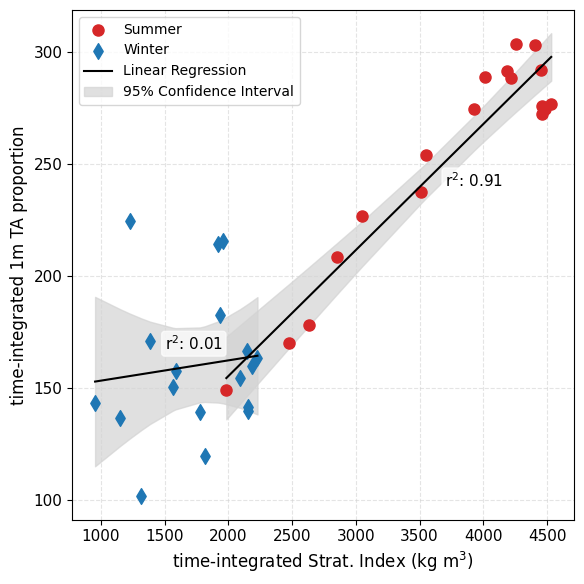

In [41]:
def regression_95percent(x,y):

    import scipy.stats as stats
    from sklearn.linear_model import LinearRegression

    sorted_indices = np.argsort(x)
    x = x[sorted_indices].reshape(-1, 1)
    y = y[sorted_indices].reshape(-1, 1)

    model = LinearRegression()
    model.fit(x,y)

    slope = model.coef_
    intercept = model.intercept_

    y_pred = model.predict(x)

    residuals = y - y_pred

    dof = len(x) - 2

    mse = np.sum(residuals**2) / dof
    se = np.sqrt(mse * (1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2)))

    t_value = stats.t.ppf(1 - 0.025, dof)

    ci = t_value *se.flatten()

    return x,y,y_pred,ci

summer_x,summer_y,summer_ypred,summer_ci = regression_95percent(np.array(summer_idx),np.array(padded_surf.sum(axis=0)))
winter_x,winter_y,winter_ypred,winter_ci = regression_95percent(np.array(winter_idx),np.array(padded_surf_winter.sum(axis=0)))

fig,ax = plt.subplots(figsize=(6,6))

ax.grid(color='lightgrey',linestyle='--',alpha=0.6,zorder=0)
ax.scatter(summer_x, summer_y, color='tab:red', label='Summer',zorder=2)
ax.scatter(winter_x, winter_y, color='tab:blue',marker='d',label='Winter',zorder=2)
ax.plot(summer_x, summer_ypred, color='black', label='Linear Regression',zorder=3)
ax.fill_between(summer_x.squeeze(), (summer_ypred.squeeze() - summer_ci), (summer_ypred.squeeze() + summer_ci), 
                   color='lightgray', label='95% Confidence Interval',zorder=0,alpha=0.7)
ax.set_xlabel('time-integrated Strat. Index (kg m$^3$)')
ax.set_ylabel('time-integrated 1m TA proportion')


ax.plot(winter_x, winter_ypred, color='black', label='_hid',zorder=3)
ax.fill_between(winter_x.squeeze(), (winter_ypred.squeeze() - winter_ci), (winter_ypred.squeeze() + winter_ci), 
                   color='lightgray', label='_hid',zorder=0,alpha=0.7)

fig.legend(loc='upper left',bbox_to_anchor=(0.133, 0.97))

ax.text(1500,167,f'r$^2$: {np.round(winter_r2,2)}',fontsize=11,
                            bbox={'facecolor': 'white', 'edgecolor':'white',
                            'alpha':0.7, 'boxstyle': 'round, pad=0.2'},zorder=7)

ax.text(3700,240,f'r$^2$: {np.round(summer_r2,2)}',fontsize=11,
                            bbox={'facecolor': 'white', 'edgecolor':'white',
                            'alpha':0.7, 'boxstyle': 'round, pad=0.2'},zorder=7)

fig.tight_layout()
#fig.savefig('Strat_TA_correlation.pdf',dpi=300)